# Paired guide correlation analysis

In [135]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sparse
import scipy.stats as stats
import sklearn.linear_model as lm
import sklearn.metrics as metrics
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [136]:
# EDIT THIS TO YOUR PATH WITH DATA
data_path = '/mnt/c/Users/minch/Data/bmdc/'

### Read AnnData

In [137]:
adata = sc.read(data_path + 'processed_bmdc_counts.h5ad')
adata.layers['counts'] = adata.X
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
num_genes = adata.shape[1]

### Create the guide design matrix

In [138]:
guide_set = set()
for g in adata.obs['guide_string']:
    guide_set |= set(g.split('-'))
guide_list = list(guide_set)
num_guides = len(guide_list)

In [139]:
design_matrix = pd.DataFrame(
    data=np.zeros((adata.shape[0], len(guide_list))), 
    index=adata.obs.index,
    columns=guide_list)

In [140]:
for cell_barcode, row in adata.obs.iterrows():
    guides = row['guide_string'].split('-')
    for g in guides:
        design_matrix.loc[cell_barcode,g] = 1

In [141]:
design_matrix.to_csv(data_path + 'analysis/design_matrix.csv')

### Save the baseline, PCA matrix

latent_0_0 is just a placeholder for PCA.

In [276]:
cell_state_matrix = pd.DataFrame(adata.obsm['X_pca'][:, :5])
cell_state_matrix.to_csv(data_path + 'analysis/latent_0_0.csv')

<Axes: xlabel='pos_ctrl', ylabel='beta_corr'>

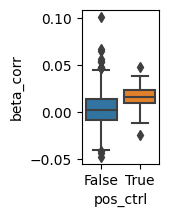

In [271]:
plt.figure(figsize=(1,2))
sns.boxplot(x='pos_ctrl', y='beta_corr', data=guide_pairs)
# sns.stripplot(x='pos_ctrl', y='beta_corr', data=guide_pairs)

In [272]:
stats.ks_2samp(
    guide_pairs.query('~pos_ctrl').beta_corr,
    guide_pairs.query('pos_ctrl').beta_corr)

KstestResult(statistic=0.48850641099688114, pvalue=2.7096539248989218e-05, statistic_location=0.005127147221198612, statistic_sign=1)

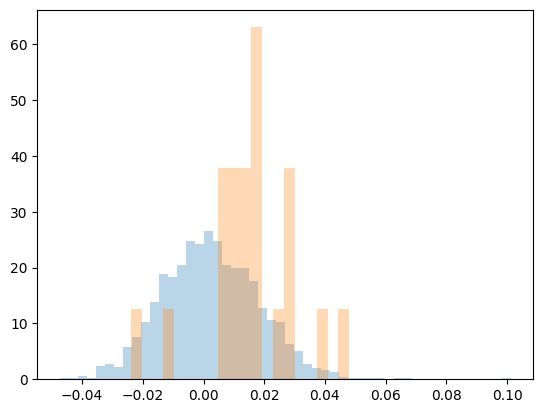

In [275]:
plt.hist(guide_pairs.query('~paired').beta_corr, density=True, bins=50, alpha=0.3);
plt.hist(guide_pairs.query('paired & sig').beta_corr, density=True, bins=20, alpha=0.3);

In [ ]:
KstestResult(statistic=0.35941438574156587, pvalue=0.0023648861080059185, statistic_location=0.002493127266733767, statistic_sign=1)


In [ ]:
KstestResult(statistic=0.4177466581795035, pvalue=0.00021037914172774972, statistic_location=0.011718687065238187, statistic_sign=1)


In [ ]:
KstestResult(statistic=0.48850641099688114, pvalue=2.7096539248989218e-05, statistic_location=0.005127147221198612, statistic_sign=1)


<Axes: xlabel='pos_ctrl', ylabel='beta_corr'>

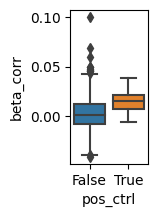

In [251]:
plt.figure(figsize=(1,2))
sns.boxplot(x='pos_ctrl', y='beta_corr', data=guide_pairs)
# sns.stripplot(x='pos_ctrl', y='beta_corr', data=guide_pairs)

In [252]:
stats.ks_2samp(
    guide_pairs.query('~pos_ctrl').beta_corr,
    guide_pairs.query('pos_ctrl').beta_corr)

KstestResult(statistic=0.4177466581795035, pvalue=0.00021037914172774972, statistic_location=0.011718687065238187, statistic_sign=1)

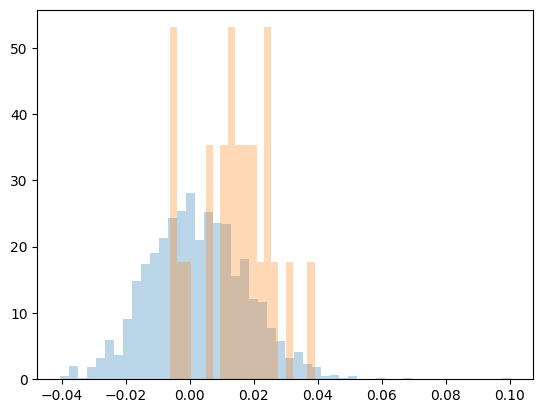

In [253]:
plt.hist(guide_pairs.query('~paired').beta_corr, density=True, bins=50, alpha=0.3);
plt.hist(guide_pairs.query('paired & sig').beta_corr, density=True, bins=20, alpha=0.3);